### Objective:

Classify species of adult foraging penguins near Palmer Station, Antarctica (Adelie, Gentoo, Chinstrap) based on their culmen length measurements and flipper length measurements. 

In [2]:
from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay

from time import time
from IPython.display import display

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
palmer_penguin_orig = pd.read_csv("data/penguins_size.csv")

In [4]:
palmer_penguin_orig.info()
palmer_penguin_orig.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
# Check for missing values

palmer_penguin_null = palmer_penguin_orig.isnull()
print(f"NO. OF MISSING VALLUES IN DF: {palmer_penguin_null.sum().sum()}")
print(f"\nNO. OF MISSING VALUES BY COLUMN: \n{palmer_penguin_null.sum()}")   
print("\nROWS WITH MISSING VALUES:")
display(palmer_penguin_orig[palmer_penguin_null.any(axis=1)])

# Drop rows with missing values of culmen_length_mm, culmen_depth_mm, flipper_length_mm, body_mass_g, and sex

print("\nREMOVE ROWS WITH MISSING VALUES:")
palmer_penguin_df = palmer_penguin_orig.dropna(
    subset=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g", "sex"],
    how="all")
palmer_penguin_df.info()


NO. OF MISSING VALLUES IN DF: 18

NO. OF MISSING VALUES BY COLUMN: 
species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

ROWS WITH MISSING VALUES:


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN



REMOVE ROWS WITH MISSING VALUES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


In [6]:
# Check for duplicate rows

palmer_penguin_dups = palmer_penguin_df.duplicated().sum()
print(f"Number of duplicate rows in dataframe: {palmer_penguin_dups}")

Number of duplicate rows in dataframe: 0


In [7]:
# Check for unique values in each column

palmer_penguin_columns = palmer_penguin_df.columns
print("Number of unique values per column:")
for column in palmer_penguin_columns:
    print(f"\t{column} - {palmer_penguin_df[column].nunique()}")

Number of unique values per column:
	species - 3
	island - 3
	culmen_length_mm - 164
	culmen_depth_mm - 80
	flipper_length_mm - 55
	body_mass_g - 94
	sex - 3


In [8]:
# Check frequency of unique values in specific columns
palmer_penguin_investigate = ["species", "island", "sex"]
for column in palmer_penguin_investigate:
    print(f"\n{column} value counts:")
    print(palmer_penguin_df[column].value_counts(ascending=False))


species value counts:
Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64

island value counts:
Biscoe       167
Dream        124
Torgersen     51
Name: island, dtype: int64

sex value counts:
MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64


In [9]:
# Check the row with "." as the value of sex

dot_sex_rows = palmer_penguin_df[palmer_penguin_df["sex"] == "."]
missing_sex_rows = palmer_penguin_df[palmer_penguin_df["sex"].isnull()]
display(dot_sex_rows)
display(missing_sex_rows)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN


In [10]:
# Extract numerical features and species

palmer_penguin_x = palmer_penguin_df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]]
palmer_penguin_y = palmer_penguin_df[["species"]]
palmer_penguin_fin = pd.concat([palmer_penguin_x, palmer_penguin_y], axis=1)

print(f"Feature Shape: {palmer_penguin_x.shape}")
print(f"Target Shape: {palmer_penguin_y.shape}")
print(f"Data Shape: {palmer_penguin_fin.shape}")

Feature Shape: (342, 4)
Target Shape: (342, 1)
Data Shape: (342, 5)


In [11]:
# Show the numerical statistics of the data
display(palmer_penguin_x.describe())

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


C:\Users\maryn\AppData\Local\Temp\ipykernel_21044\2497791333.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = palmer_penguin_fin.corr()


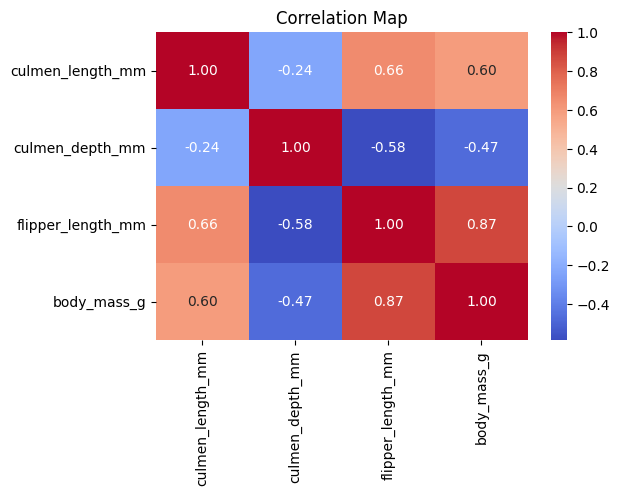

In [12]:
corr = palmer_penguin_fin.corr()

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Map')
plt.show()

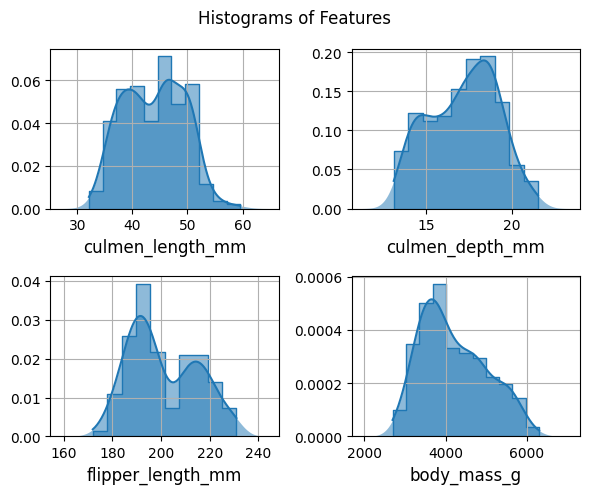

In [13]:
# Histograms of features with KDE

sns.reset_defaults()
fig, axes = plt.subplots(2, 2, figsize=(6,5))

for i, ax in enumerate(axes.flatten()):
    column = palmer_penguin_x.columns[i]
    sns.histplot(data=palmer_penguin_fin, x=column, 
                 element="step", stat="density", common_norm=False, ax=ax, kde=True)
    sns.kdeplot(data=palmer_penguin_fin, x=column, 
                fill=True, common_norm=False, alpha=.5, linewidth=0, ax=ax)
    ax.set_ylabel("") 
    ax.set_xlabel(column, fontsize=12)
    ax.grid(True)
    
fig.suptitle("Histograms of Features", fontsize=12)
plt.tight_layout()
plt.show()

<mark> Visualize the 4 numerical features of the data using Seaborn’s pair plot, then set the hue to the penguin species </mark>

<Figure size 1200x1200 with 0 Axes>

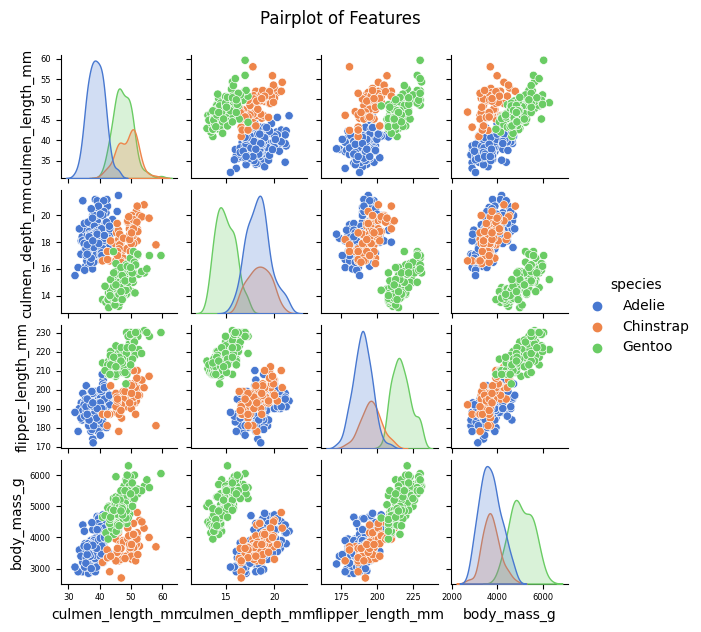

In [14]:
# Pairplot of features with hue as species

sns.reset_defaults()
plt.figure(figsize=(12,12))
pairplot = sns.pairplot(palmer_penguin_fin, hue='species', height=1.5, palette='muted')
plt.suptitle('Pairplot of Features', fontsize=12, y=1.05)
# Make the axis labels smaller
for ax in pairplot.axes.flatten():
    ax.tick_params(axis='both', labelsize=6)

plt.show()

<mark> Train the model using the default settings for multi-class SVC in sklearn. Report the accuracy, macro-averaged F1-score, and confusion matrix of the trained model separately for the training data and testing data. </mark>

In [15]:
# Split data into train and test set
palmer_penguin_y_ = palmer_penguin_y["species"]
palmer_penguin_x_ = palmer_penguin_x[["culmen_length_mm", "flipper_length_mm"]]
pp_x_train, pp_x_test, pp_y_train, pp_y_test = train_test_split(palmer_penguin_x_, palmer_penguin_y_, 
                                                                test_size=0.25, random_state=42, stratify=palmer_penguin_y)
print(f"X Train Shape: {pp_x_train.shape}")
print(f"Y Train Shape: {pp_y_train.shape}")
print(f"X Test Shape: {pp_x_test.shape}")
print(f"Y Test Shape: {pp_y_test.shape}")

X Train Shape: (256, 2)
Y Train Shape: (256,)
X Test Shape: (86, 2)
Y Test Shape: (86,)


In [16]:
# Train an SVC model
pp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())]).fit(pp_x_train, pp_y_train)

display(pp_pipeline)


Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

In [17]:
# Extract train and test accuracy of model
pp_accuracy_train = pp_pipeline.score(pp_x_train, pp_y_train)
pp_accuracy_test = pp_pipeline.score(pp_x_test, pp_y_test)

# Extract predictions of model
pp_pred_train = pp_pipeline.predict(pp_x_train)
pp_pred_test = pp_pipeline.predict(pp_x_test)

# Calculate macro-averaged F1-score
pp_f1_train = f1_score(pp_y_train, pp_pred_train, average="macro")
pp_f1_test = f1_score(pp_y_test, pp_pred_test, average="macro")

# Create dataframe with evaluation metrics
pp_init_evaluation = {
    "Feature": ["Default", "Default"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [pp_accuracy_train, pp_accuracy_test],
    "Macro-averaged F1 Score": [pp_f1_train, pp_f1_test]}

pp_init_evaluation = pd.DataFrame(pp_init_evaluation)
pp_init_evaluation = pp_init_evaluation.round({"Accuracy": 4,
                                     "Macro-averaged F1 Score": 4})

display(pp_init_evaluation)

,Feature,Dataset,Accuracy,Macro-averaged F1 Score
0,Default,Train,0.9453,0.9338
1,Default,Test,0.9884,0.9856


In [18]:
# classification report

print("CLASSIFICATION REPORT FOR TRAIN DATA")
print(classification_report(pp_y_train, pp_pred_train))

print("CLASSIFICATION REPORT FOR TEST DATA")
print(classification_report(pp_y_test, pp_pred_test))

CLASSIFICATION REPORT FOR TRAIN DATA
              precision    recall  f1-score   support

      Adelie       0.96      0.96      0.96       113
   Chinstrap       0.91      0.84      0.88        51
      Gentoo       0.95      0.99      0.97        92

    accuracy                           0.95       256
   macro avg       0.94      0.93      0.93       256
weighted avg       0.94      0.95      0.94       256

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.99        38
   Chinstrap       1.00      0.94      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



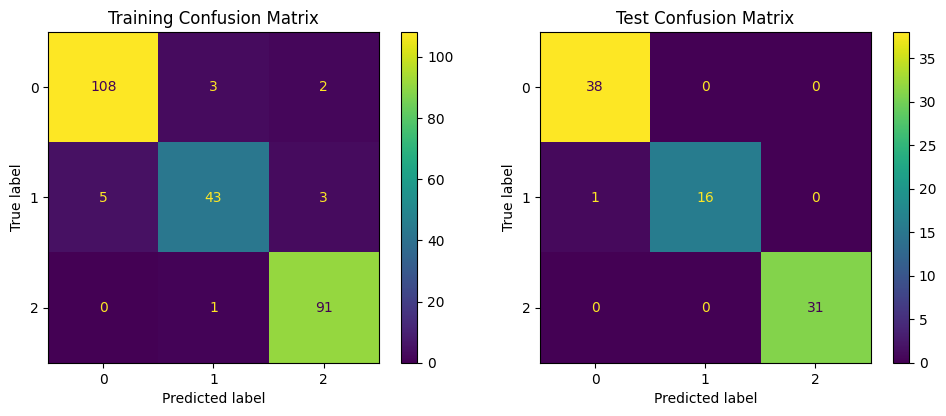

In [19]:
# Create a confusion matrix 

pp_confusion_matrix_train = confusion_matrix(pp_y_train, pp_pred_train)
pp_confusion_matrix_test = confusion_matrix(pp_y_test, pp_pred_test)

plt.rcdefaults()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = pp_confusion_matrix_train)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = pp_confusion_matrix_test)

cm_display_train.plot(ax=ax[0])
ax[0].set_title("Training Confusion Matrix", fontsize=12)
cm_display_test.plot(ax=ax[1])
ax[1].set_title("Test Confusion Matrix", fontsize=12)

plt.tight_layout()
plt.show()

<mark> Visualize the decision boundary in the space of culmen length vs. flipper length. Add a scatter plot of the training and test data set </mark>

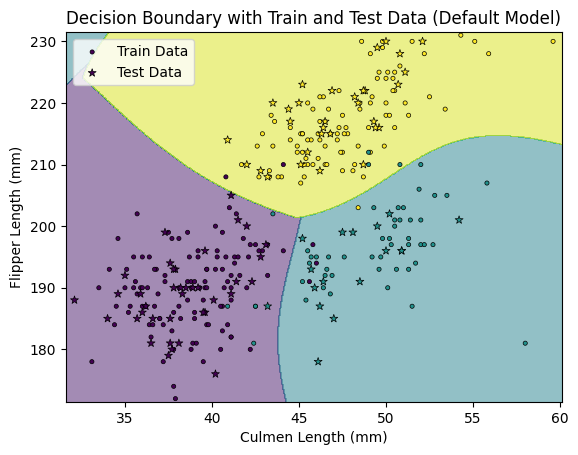

In [20]:
# Decision boundary in the space of culmen length vs. flipper length. Scatter plot of the training and test data set.

pp_label_encoder = LabelEncoder()
pp_y_train_encoded = pp_label_encoder.fit_transform(pp_y_train)
pp_y_test_encoded = pp_label_encoder.transform(pp_y_test) 

pp_disp = DecisionBoundaryDisplay.from_estimator(pp_pipeline, palmer_penguin_x_, 
                                                 grid_resolution = 500, alpha = 0.5, eps = 0.5,
                                                 xlabel = "Culmen Length (mm)", ylabel = "Flipper Length (mm)")
plt.scatter(pp_x_train["culmen_length_mm"], pp_x_train["flipper_length_mm"], c=pp_y_train_encoded, 
            edgecolors="black", linewidths = 0.5, marker=".", label="Train Data")
plt.scatter(pp_x_test["culmen_length_mm"], pp_x_test["flipper_length_mm"], c=pp_y_test_encoded,
            edgecolors="black", linewidths = 0.5, marker="*", label="Test Data")
plt.title("Decision Boundary with Train and Test Data (Default Model)")
plt.legend()
plt.show()


<mark> Find a better model by varying the box constraint, kernel function, kernel parameter, and multi-class strategy. Report the metrics of the best SVC model. </mark>

In [21]:
# Hyperparameter Tuning of SVC

pp_param = {"model__C": [0.001, 0.01, 0.1, 1, 10, 100],
            "model__degree": [2, 3, 4, 5],
            "model__kernel": ["rbf","linear","poly","sigmoid"],
            "model__decision_function_shape": ["ovr", "ovo"]
}

pp_best_search = RandomizedSearchCV(pp_pipeline, param_distributions=pp_param, 
                                      cv=5, verbose=2, scoring="accuracy", random_state=42)

start = time()
pp_best_search.fit(pp_x_train, pp_y_train)
print("RandomizedSearchCV took %.2f seconds." % (time() - start))

pp_best_params = pp_best_search.best_params_
pp_best_pipeline = pp_best_search.best_estimator_

display(pp_best_pipeline)
display(pp_best_params)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__C=0.01, model__decision_function_shape=ovr, model__degree=5, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.01, model__decision_function_shape=ovr, model__degree=5, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.01, model__decision_function_shape=ovr, model__degree=5, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.01, model__decision_function_shape=ovr, model__degree=5, model__kernel=linear; total time=   0.0s
[CV] END model__C=0.01, model__decision_function_shape=ovr, model__degree=5, model__kernel=linear; total time=   0.0s
[CV] END model__C=10, model__decision_function_shape=ovr, model__degree=4, model__kernel=rbf; total time=   0.0s
[CV] END model__C=10, model__decision_function_shape=ovr, model__degree=4, model__kernel=rbf; total time=   0.0s
[CV] END model__C=10, model__decision_function_shape=ovr, model__degree=4, model__kernel=rbf; total time=   0.0s
[CV] END m

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(C=10, degree=4))])

{'model__kernel': 'rbf',
 'model__degree': 4,
 'model__decision_function_shape': 'ovr',
 'model__C': 10}

In [22]:
# Extract train and test accuracy and F1 score of best model and compare with the initial model

pp_best_accuracy_train = pp_best_pipeline.score(pp_x_train, pp_y_train)
pp_best_accuracy_test = pp_best_pipeline.score(pp_x_test, pp_y_test)

pp_best_pred_test = pp_best_pipeline.predict(pp_x_test)
pp_best_pred_train = pp_best_pipeline.predict(pp_x_train)

pp_best_f1_train = f1_score(pp_y_train, pp_best_pred_train, average="macro")
pp_best_f1_test = f1_score(pp_y_test, pp_best_pred_test, average="macro")

pp_best_evaluation = {
    "Feature": ["Best", "Best"],
    "Dataset": ["Train", "Test"],
    "Accuracy": [pp_best_accuracy_train, pp_best_accuracy_test],
    "Macro-averaged F1 Score": [pp_best_f1_train, pp_best_f1_test]}

pp_best_evaluation = pd.DataFrame(pp_best_evaluation)
pp_best_evaluation = pp_best_evaluation.round({"Accuracy": 4,
                                     "Macro-averaged F1 Score": 4})

pp_evaluation = pd.concat([pp_init_evaluation, pp_best_evaluation])
pp_evaluation = pp_evaluation.sort_values(by="Accuracy", ascending=False)
pp_evaluation = pp_evaluation.reset_index(drop=True)

display(pp_evaluation)

,Feature,Dataset,Accuracy,Macro-averaged F1 Score
0,Best,Test,1.0000,1.0000
1,Default,Test,0.9884,0.9856
2,Best,Train,0.9492,0.9393
3,Default,Train,0.9453,0.9338


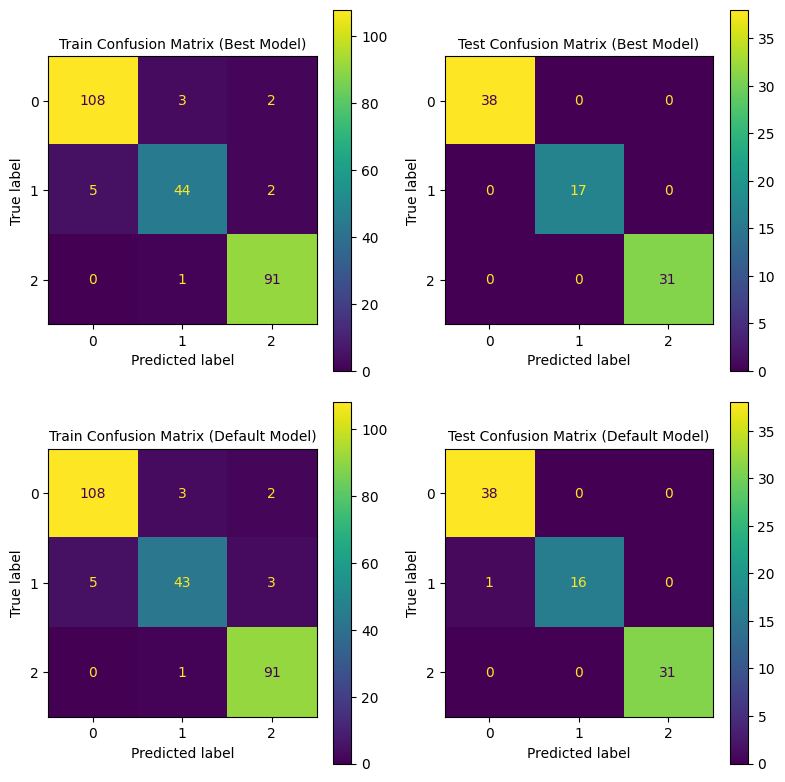

In [23]:
# Create a confusion matrix 

pp_best_confusion_matrix_train = confusion_matrix(pp_y_train, pp_best_pred_train)
pp_best_confusion_matrix_test = confusion_matrix(pp_y_test, pp_best_pred_test)

plt.rcdefaults()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

cm_best_display_train = ConfusionMatrixDisplay(confusion_matrix = pp_best_confusion_matrix_train)
cm_best_display_test = ConfusionMatrixDisplay(confusion_matrix = pp_best_confusion_matrix_test)

cm_best_display_train.plot(ax=ax[0][0])
ax[0][0].set_title('Train Confusion Matrix (Best Model)', fontsize=10)
cm_best_display_test.plot(ax=ax[0][1])
ax[0][1].set_title('Test Confusion Matrix (Best Model)', fontsize=10)
cm_display_train.plot(ax=ax[1][0])
ax[1][0].set_title('Train Confusion Matrix (Default Model)', fontsize=10)
cm_display_test.plot(ax=ax[1][1])
ax[1][1].set_title('Test Confusion Matrix (Default Model)', fontsize=10)

plt.tight_layout()
plt.show()

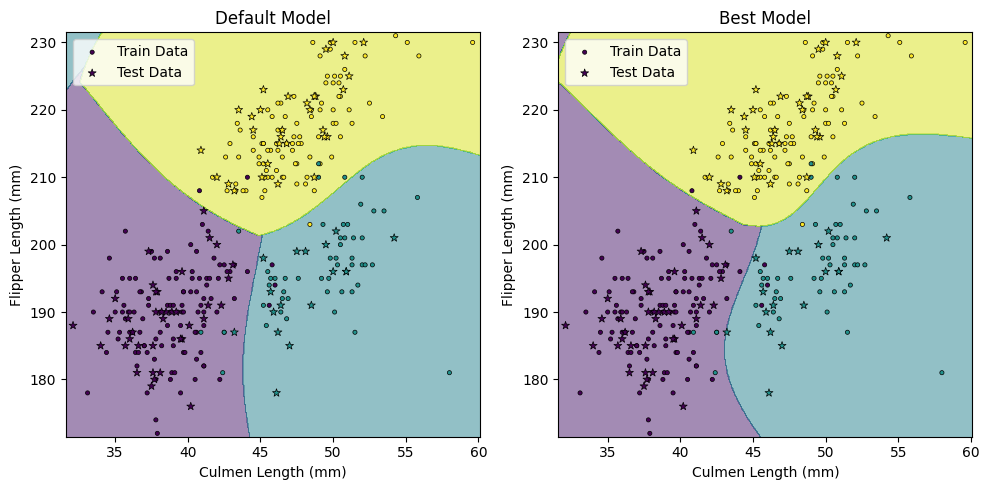

In [24]:
# Decision boundary in the space of culmen length vs. flipper length. Scatter plot of the training and test data set.

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pp_disp = DecisionBoundaryDisplay.from_estimator(pp_pipeline, palmer_penguin_x_, 
                                                 grid_resolution = 500, alpha = 0.5, eps = 0.5,
                                                 xlabel = "Culmen Length (mm)", ylabel = "Flipper Length (mm)", ax=axs[0])
axs[0].scatter(pp_x_train["culmen_length_mm"], pp_x_train["flipper_length_mm"], c=pp_y_train_encoded, 
            edgecolors="black", linewidths = 0.5, marker=".", label="Train Data")
axs[0].scatter(pp_x_test["culmen_length_mm"], pp_x_test["flipper_length_mm"], c=pp_y_test_encoded,
            edgecolors="black", linewidths = 0.5, marker="*", label="Test Data")
axs[0].set_title("Default Model")
axs[0].legend()


pp_best_disp = DecisionBoundaryDisplay.from_estimator(pp_best_pipeline, palmer_penguin_x_, 
                                                 grid_resolution = 500, alpha = 0.5, eps = 0.5,
                                                 xlabel = "Culmen Length (mm)", ylabel = "Flipper Length (mm)", ax=axs[1])
axs[1].scatter(pp_x_train["culmen_length_mm"], pp_x_train["flipper_length_mm"], c=pp_y_train_encoded, 
            edgecolors="black", linewidths = 0.5, marker=".", label="Train Data")
axs[1].scatter(pp_x_test["culmen_length_mm"], pp_x_test["flipper_length_mm"], c=pp_y_test_encoded,
            edgecolors="black", linewidths = 0.5, marker="*", label="Test Data")
axs[1].set_title("Best Model")
axs[1].legend()

plt.tight_layout()
plt.show()

## Summary Insights



**Pair Plot**
- Visualization of how different species are distributed and how they relate to each other
- Distinct clusters seen for the following scatter plots:
    - Culmen Length (mm) x Culmen Depth (mm)
    - Culmen Length (mm) x Flipper Length (mm)
    - Culmen Length (mm) x Body Mass (g)

**Model before Hyperparameter Tuning**
- SVC model performed well in classifying penguin data by their species using only culmen length and flipper length features during training and testing
- SVC model performed better with test data than with train data
- Recommendations: 
    - Check how other features affect the model
- Some of the train and test data points crossed the decision boundary outside of their class. They are deemed as misclassifications 

**Model after Hyperparamter Tuning**
- SVC model improved after hyperparameter tuning.
- Decision boundary changed after hyperparameter tuning, resulting to less misclassifications.
